## VKITTI 데이터셋 라벨을 YOLOv5 포맷으로 변경하기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 이미지와 라벨 root directory
img_root = '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb'
gt_root = '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_textgt'

### 이미지 경로 모으기
- 모아놓은 이미지 경로를 통해 1:1 매칭되는 라벨 경로를 만들어서 데이터를 추출할 예정

In [3]:
# 이미지 경로 모으기
img_path_list = []
for (dirpath, dirnames, filenames) in os.walk(img_root):
    for file in filenames:
        combined_path = os.path.join(dirpath, file)
        if 'Camera_1' in combined_path: # 현재 Camera_0만 사용
            continue
        elif '.DS_Store' in combined_path:
            continue
        else:
            img_path_list += [combined_path]

In [4]:
# 개수 확인
# 21260개 나와야 함
print(len(img_path_list))

21260


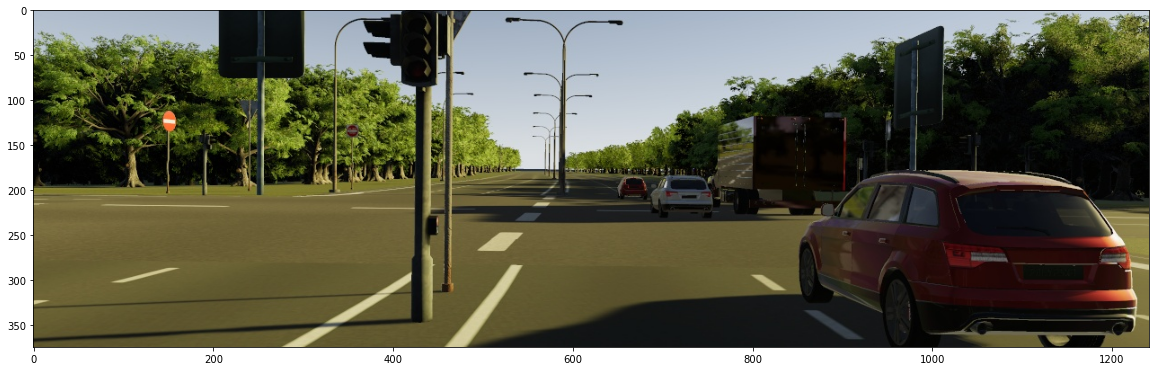

In [5]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(img_path_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10))
plt.imshow(img)

In [6]:
import numpy as np

# 무작위로 섞은 1000개만 사용
permuted_paths = np.random.permutation(img_path_list)
permuted_paths[:100]

array(['/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/15-deg-left/frames/rgb/Camera_0/rgb_00041.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene18/30-deg-left/frames/rgb/Camera_0/rgb_00120.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene01/sunset/frames/rgb/Camera_0/rgb_00275.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/sunset/frames/rgb/Camera_0/rgb_00210.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/sunset/frames/rgb/Camera_0/rgb_00215.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/15-deg-right/frames/rgb/Camera_0/rgb_00116.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene18/30-deg-left/frames/rgb/Camera_0/rgb_00104.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene20/morning/frames/rgb/Camera_0/rgb_00021.jpg',
       '/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene01/15-deg-right/frames/rgb/Camera_0/rgb_00075.jpg',
       '/Users/Jinmi/Desktop/vkitti/

### 매칭되는 라벨 가져오기

In [9]:
img_path_list[0]

'/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene06/morning/frames/rgb/Camera_0/rgb_00092.jpg'

In [11]:
gt_root

'/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_textgt'

#### 샘플로 하나 가져오기

In [59]:
path = img_path_list[10000]

In [60]:
# 숫자로 바꿔주기
# YOLOv5에서는 0부터 시작해야 함
def label_mapping(string):
    map_dict = {'Car' : 0,
                'Van' : 1,
                'Truck' : 2,
                }
    return map_dict[string]

# 이미지에서 width, height 가져오기
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height = img.shape[0]
width = img.shape[1]

# 이미지 경로 중 textgt 경로와 매칭되는 정보 할당
parent_dir_idx = path.find('vkitti_2.0.3_rgb')
necessary_dir = path[parent_dir_idx:]

scene_name = necessary_dir.split('/')[1]
weather_name = necessary_dir.split('/')[2]
shot_name = necessary_dir.split('/')[-1][-9:-4]
camera_name = necessary_dir.split('/')[-2][-1]

# textgt 경로 및 df로 만들기
bbox_filename = os.path.join(gt_root, scene_name, weather_name, 'bbox.txt')
info_filename = os.path.join(gt_root, scene_name, weather_name, 'info.txt')
bbox_df = pd.read_csv(bbox_filename, sep=' ')
info_df = pd.read_csv(info_filename, sep=' ')

# bbox 정보 + 라벨 정보 합치기
combined_df = pd.merge(bbox_df, info_df[['trackID', 'label']], on='trackID')

# textgt 중 이미지 번호, 카메라 번호 등 궁극적으로 1대1 매칭되는 정보만 가져오기
condition_1 = combined_df['frame'] == int(shot_name)
condition_2 = combined_df['cameraID'] == int(camera_name)
picked = combined_df[condition_1 & condition_2]

# height, width가 0이어서 오류났던 거 해결
picked = picked[picked.loc[:, 'right'] - picked.loc[:, 'left'] > 0]
picked = picked[picked.loc[:, 'bottom'] - picked.loc[:, 'top'] > 0]

picked['label_int'] = picked['label'].map(label_mapping)

picked['ob_width'] = picked['right'] - picked['left']
picked['ob_height'] = picked['bottom'] - picked['top']
picked['x_center'] = picked['ob_width'] / 2 + picked['left']
picked['y_center'] = picked['ob_height'] / 2 + picked['top']
picked['norm_x_center'] = picked['x_center'] / width
picked['norm_y_center'] = picked['y_center'] / height
picked['norm_ob_width'] = picked['ob_width'] / width
picked['norm_ob_height'] = picked['ob_height'] / height


# df_to_save = picked.loc[:, ['class_int', 'norm_x_center', 'norm_y_center', 'norm_ob_width', 'norm_ob_height']]
# df_to_save.to_csv(os.path.join(to_path, img_id + '.txt'), sep=' ', index=False, header=False)

In [61]:
picked

,frame,cameraID,trackID,left,right,top,bottom,number_pixels,truncation_ratio,occupancy_ratio,...,label,label_int,ob_width,ob_height,x_center,y_center,norm_x_center,norm_y_center,norm_ob_width,norm_ob_height
306,191,0,1,0,574,209,374,58994,0.553376,0.622891,...,Car,0,574,165,287.0,291.5,0.231079,0.777333,0.462158,0.440000
686,191,0,3,798,863,176,230,2362,0.000000,0.672934,...,Car,0,65,54,830.5,203.0,0.668680,0.541333,0.052335,0.144000
1228,191,0,6,727,785,177,224,2067,0.000000,0.758254,...,Car,0,58,47,756.0,200.5,0.608696,0.534667,0.046699,0.125333
1740,191,0,2,586,715,190,284,7872,0.000000,0.649184,...,Car,0,129,94,650.5,237.0,0.523752,0.632000,0.103865,0.250667
2212,191,0,10,549,645,175,241,2927,0.000000,0.461963,...,Van,1,96,66,597.0,208.0,0.480676,0.554667,0.077295,0.176000


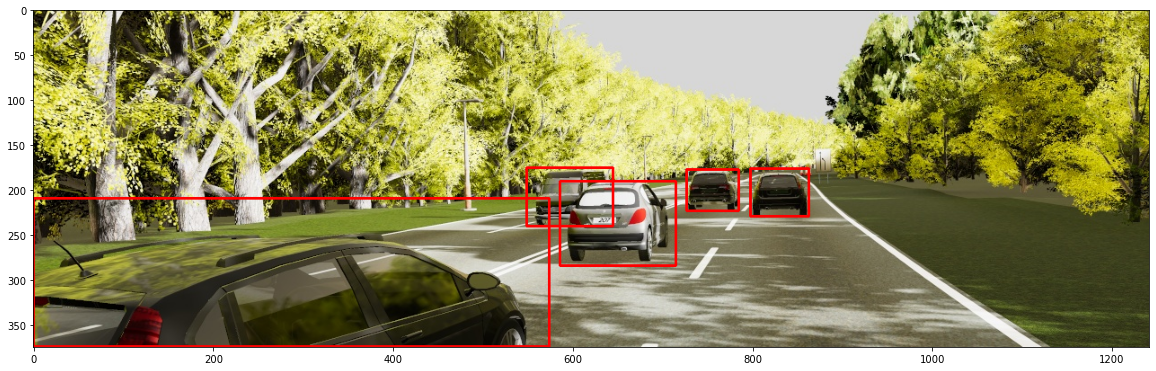

In [62]:
img_copy = img.copy()

for box in picked.loc[:, ['norm_x_center', 'norm_y_center', 'norm_ob_width', 'norm_ob_height']].to_numpy():
    xmin = int((box[0] - box[2] / 2) * width)
    xmax = int((box[0] + box[2] / 2) * width)
    ymin = int((box[1] - box[3] / 2) * height)
    ymax = int((box[1] + box[3] / 2) * height)
    cv2.rectangle(img_copy, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2) 

plt.figure(figsize=(20, 10))
plt.imshow(img_copy)

### YOLOv5 포맷으로 변경 및 저장
- YOLOv5는 라벨과 이미지가 1:1 매칭으로 같은 filename을 갖고 확장자만 달라야 한다.

In [63]:
# 샘플 이미지 경로
img_path_list[0]

'/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene06/morning/frames/rgb/Camera_0/rgb_00092.jpg'

In [75]:
# 이미지 경로와 같은 라벨 filename 만들어주기
txt_to_path = '+'.join([scene_name, weather_name, 'frames', 'rgb', 'Camera_'+camera_name, 'rgb_'+ shot_name + '.txt'])

In [76]:
# 이미지 경로의 filename도 동일하게 맞춰주기
img_to_path = '+'.join(necessary_dir.split('/')[1:])

In [77]:
txt_to_path[:-3] == img_to_path[:-3]

True

In [88]:
%%time
import shutil

# 숫자로 바꿔주기
# YOLOv5에서는 0부터 시작해야 함
def label_mapping(string):
    map_dict = {'Car' : 0,
                'Van' : 1,
                'Truck' : 2,
                }
    return map_dict[string]

# 새로운 라벨을 저장할 폴더
label_output_dir = '/Users/Jinmi/Desktop/vkitti_yolov5_1000_labels'
if not os.path.exists(label_output_dir):
    os.mkdir(label_output_dir)

# 새로운 이미지를 복사해서 붙여넣을 폴더
img_output_dir = '/Users/Jinmi/Desktop/vkitti_yolov5_1000_images'
if not os.path.exists(img_output_dir):
    os.mkdir(img_output_dir)

for path in permuted_paths[:1000]:   # 1000개만 사용 
    # 이미지에서 width, height 가져오기
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height = img.shape[0]
    width = img.shape[1]

    # 이미지 경로 중 textgt 경로와 매칭되는 정보 할당
    parent_dir_idx = path.find('vkitti_2.0.3_rgb')
    necessary_dir = path[parent_dir_idx:]

    scene_name = necessary_dir.split('/')[1]
    weather_name = necessary_dir.split('/')[2]
    shot_name = necessary_dir.split('/')[-1][-9:-4]
    camera_name = necessary_dir.split('/')[-2][-1]

    # textgt 경로 및 df로 만들기
    bbox_filename = os.path.join(gt_root, scene_name, weather_name, 'bbox.txt')
    info_filename = os.path.join(gt_root, scene_name, weather_name, 'info.txt')
    bbox_df = pd.read_csv(bbox_filename, sep=' ')
    info_df = pd.read_csv(info_filename, sep=' ')

    # bbox 정보 + 라벨 정보 합치기
    combined_df = pd.merge(bbox_df, info_df[['trackID', 'label']], on='trackID')

    # textgt 중 이미지 번호, 카메라 번호 등 궁극적으로 1대1 매칭되는 정보만 가져오기
    condition_1 = combined_df['frame'] == int(shot_name)
    condition_2 = combined_df['cameraID'] == int(camera_name)
    picked = combined_df[condition_1 & condition_2]

    # height, width가 0이어서 오류났던 거 해결
    picked = picked[picked.loc[:, 'right'] - picked.loc[:, 'left'] > 0]
    picked = picked[picked.loc[:, 'bottom'] - picked.loc[:, 'top'] > 0]

    picked['label_int'] = picked['label'].map(label_mapping)

    picked['ob_width'] = picked['right'] - picked['left']
    picked['ob_height'] = picked['bottom'] - picked['top']
    picked['x_center'] = picked['ob_width'] / 2 + picked['left']
    picked['y_center'] = picked['ob_height'] / 2 + picked['top']
    picked['norm_x_center'] = picked['x_center'] / width
    picked['norm_y_center'] = picked['y_center'] / height
    picked['norm_ob_width'] = picked['ob_width'] / width
    picked['norm_ob_height'] = picked['ob_height'] / height

    # 이미지, 라벨 이름 맞춰주기
    txt_to = '+'.join([scene_name, weather_name, 'frames', 'rgb', 'Camera_'+camera_name, 'rgb_'+ shot_name + '.txt'])
    txt_to_path = os.path.join(label_output_dir, txt_to)
    img_to = '+'.join(necessary_dir.split('/')[1:])
    img_to_path = os.path.join(img_output_dir, img_to)
    
    if not txt_to[:-3] == img_to[:-3]:
        raise Exception("txt_to_path and img_to_path don't match")

    df_to_save = picked.loc[:, ['label_int', 'norm_x_center', 'norm_y_center', 'norm_ob_width', 'norm_ob_height']]
    df_to_save.to_csv(txt_to_path, sep=' ', index=False, header=False)

    shutil.copy(path, img_to_path)


CPU times: user 42.4 s, sys: 8.16 s, total: 50.6 s
Wall time: 56.8 s


#### 이미지 경로 및 라벨 경로 확인

In [89]:
img_to_path

'/Users/Jinmi/Desktop/vkitti_yolov5_1000_images/Scene01+15-deg-left+frames+rgb+Camera_0+rgb_00252.jpg'

In [90]:
txt_to_path

'/Users/Jinmi/Desktop/vkitti_yolov5_1000_labels/Scene01+15-deg-left+frames+rgb+Camera_0+rgb_00252.txt'

#### 추출한 이미지 리스트 txt로 만들어놓기

In [92]:
with open('/Users/Jinmi/Desktop/vkitti_yolov5_1000_list.txt', 'w') as f:
    for line in permuted_paths[:1000]:
        f.write(line + '\n')

In [94]:
with open('/Users/Jinmi/Desktop/vkitti_yolov5_1000_list.txt', 'r') as f:
    print(f.read())

/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/15-deg-left/frames/rgb/Camera_0/rgb_00041.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene18/30-deg-left/frames/rgb/Camera_0/rgb_00120.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene01/sunset/frames/rgb/Camera_0/rgb_00275.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/sunset/frames/rgb/Camera_0/rgb_00210.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/sunset/frames/rgb/Camera_0/rgb_00215.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene02/15-deg-right/frames/rgb/Camera_0/rgb_00116.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene18/30-deg-left/frames/rgb/Camera_0/rgb_00104.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene20/morning/frames/rgb/Camera_0/rgb_00021.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene01/15-deg-right/frames/rgb/Camera_0/rgb_00075.jpg
/Users/Jinmi/Desktop/vkitti/vkitti_2.0.3_rgb/Scene20/sunset/frames/rgb/Camera_0/rgb_00139.jpg
/Users/Jinmi/Desktop/vkitti/vkit

#### 추출한 이미지 개수 및 라벨 클래스 종류 확인
- 아래만 kernel 새롭게 시작

In [3]:
import os

labels = os.listdir('/Users/Jinmi/Desktop/vkitti_yolov5_1000_labels')

label_counts = 0
classes = set()
for label in labels:
    with open(os.path.join('/Users/Jinmi/Desktop/vkitti_yolov5_1000_labels', label), 'r') as f:
        label_counts += 1
        for line in f:
            classes.add(line[0])

print(label_counts)
print(classes)

1000
{'0', '1', '2'}
